If time to event has the probability density function $f(t)$ and cumulative distribution function $F(t)$, then the probability of surviving at least to time $t$ is: $Pr(T>t)=S(t)=1-F(t)$. 

Cumulative hazard at time t is defined as $H(t)=-ln(S(t))$ and instantaneous hazard at time $t$ is $h(t)=\frac{dH(t)}{dt}$. The instantateous hazard can also be written as $h(t)=\frac{f(t)}{S(t)}$

The likelihood function for survival analysis is described as:

$$ l(\beta) = \prod_{n=1}^{n} h(t_{i})^{d_{i}} S(t_{i}) $$
where $d_i$ is the censoring variable that equals to 1 if the event is observed for individual $i$ and 0 if the event is not observed (censored) for individual $i$, $h(t_i)$ is the hazard for individual $i$ at time $t$, $H(t_i)$ is the cumulative hazard for individual $i$ at time $t$, and $S(t_i)$ is the survival probability for individual $i$ at time $t$. Note that when $d_i=0$, the contribution of the $i$'th individual to the likelihood function is just its survival probability until time $t$: S(t). If the individual has the event, the contribution to the likelihood function is given by the density function $f(t)=h(t)S(t)$.

The log of likelihood is:

$$ logl(\beta) = \sum_{i=1}^n d_i log(h(t_i)) - H(t_i) $$
where $log$ is the natural logarithm.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.stats import norm
import statsmodels.api as st
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [4]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
data.Churn = labelencoder.fit_transform(data.Churn)
data.Churn.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [7]:
## for survival analysis we need two elements (variables of interest)
# 1. Time to event (duration)
# 2. Event indicator (whether the event occurred)

timevar = data["tenure"]
eventvar = data["Churn"]

In [8]:
# Convert TotalCharges to numeric (handle whitespace values)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Remove rows with missing values
data.dropna(inplace=True)

# Create numeric target variable for correlation analysis (Yes=1, No=0)
data['Churn_Num'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print("Dataset shape:", data.shape)
display(data.head())

Dataset shape: (7032, 22)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Num
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


In [9]:
#droping the CustomerID column as it is not useful for analysis
data.drop('customerID', axis=1, inplace=True)

In [10]:
categorical = data.select_dtypes(include=['object', 'category']).columns

survivaldata = pd.get_dummies(
    data,
    columns=categorical,
    drop_first=True

)

survivaldata.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Churn_Num,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,0,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,0,True,False,False,True,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,0,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,0,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False


In [11]:
survivaldata.drop(['tenure', 'Churn'], axis = 1, inplace= True)
survivaldata = st.add_constant(survivaldata, prepend=False)
survivaldata.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Num,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,const
0,0,29.85,29.85,0,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,1.0
1,0,56.95,1889.50,0,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,1.0
2,0,53.85,108.15,0,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,1.0
3,0,42.30,1840.75,0,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,1.0
4,0,70.70,151.65,0,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,1.0


### Kaplan-Meier Survival Curves

The Kaplan–Meier method calculates the probability of survival at time $t$ as:

$$
S(t) = \prod_{i=1}^{t-1} \left(1 - \frac{d_i}{n_i}\right)
$$

where $S(t)$ is the probability of survival until time $t$, $d_i$ is the number of units that experienced the event at time $i$, and $n_i$ is the number of units at risk at time $i$.

This method is non-parametric and relies solely on observed event times and censoring information.

<img src="keplan.png" width="600"/>

**Figure:** Kaplan–Meier survival curve illustrating the estimated survival probability over time.


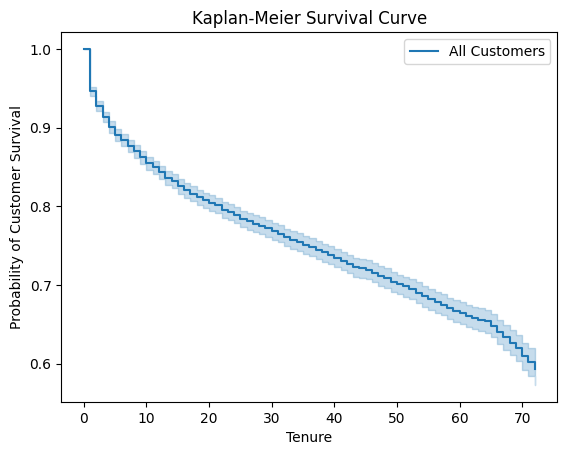

In [12]:
#initialising the kaplan meier fitter
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All Customers")

kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Survival Curve');

At the beginning of the observation period, the survival probability is equal to one, indicating that all customers are initially active. A noticeable decline occurs within the early tenure period, suggesting that customer attrition is highest shortly after onboarding. This indicates the presence of early-stage churn, which may be associated with unmet expectations, pricing concerns, or service-related issues.

As tenure increases, the survival curve declines more gradually, implying that customers who remain beyond the initial periods exhibit a lower risk of churn. This pattern suggests that customer loyalty strengthens over time, and long-tenured customers are more likely to continue their subscription. Towards the later stages of tenure, the survival probability continues to decrease but at a slower rate, indicating relatively stable retention among long-standing customers.

The shaded confidence intervals around the survival curve reflect the uncertainty in the survival estimates. These intervals widen slightly at higher tenure values, which is expected due to the reduced number of customers at risk as time progresses. Overall, the Kaplan–Meier analysis highlights that customer churn risk is time-dependent, with the highest risk occurring early in the customer lifecycle.